In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
import cv2 as cv
import skimage.color
import pdb
print(tf.__version__)

2.2.0


In [ ]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=4
def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('_')[0]
    #print(category)
    if category == 'AU': #Au

      categories.append(1)
    else:
      #pdb.set_trace()
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [ ]:
df=get_pathframe("/content/drive/My Drive/DVMM/Au-S/")
df.tail(1000)
len(df.category)
#(df.category==0).sum()

1845

In [ ]:
def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_bmp(image, channels=0)
  #image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])

  image = tf.image.grayscale_to_rgb(image)
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)


  return image_ds,label_ds


In [ ]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)


Shape of X in data: <MapDataset shapes: (128, 128, 3), types: tf.float32>
Shape of Y in data: <TensorSliceDataset shapes: (), types: tf.int64>


In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=1845)
#dataset_train=dataset.take(1845)
#dataset_test=dataset.skip(1476)
DATASET_SIZE=1845

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

dataset_train = dataset.take(train_size)
dataset_test = dataset.skip(train_size)
dataset_test = dataset_test.take(test_size)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
print(dataset_train)
dataset.element_spec


<BatchDataset shapes: ((4, 128, 128, 3), (4,)), types: (tf.float32, tf.int64)>


(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

**Transfer learning **

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='softmax')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
vgghist=vggmodel.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)

Epoch 1/20
369/369 [==============================] - 7s 20ms/step - loss: 0.6944 - accuracy: 0.5874 - val_loss: 0.5953 - val_accuracy: 0.6848
Epoch 2/20
369/369 [==============================] - 7s 20ms/step - loss: 0.6061 - accuracy: 0.6707 - val_loss: 0.5034 - val_accuracy: 0.7853
Epoch 3/20
369/369 [==============================] - 7s 20ms/step - loss: 0.5269 - accuracy: 0.7405 - val_loss: 0.4586 - val_accuracy: 0.8016
Epoch 4/20
369/369 [==============================] - 7s 20ms/step - loss: 0.4769 - accuracy: 0.7696 - val_loss: 0.4004 - val_accuracy: 0.8071
Epoch 5/20
369/369 [==============================] - 7s 20ms/step - loss: 0.4483 - accuracy: 0.7832 - val_loss: 0.3576 - val_accuracy: 0.8424
Epoch 6/20
369/369 [==============================] - 7s 20ms/step - loss: 0.3962 - accuracy: 0.8272 - val_loss: 0.3873 - val_accuracy: 0.8152
Epoch 7/20
369/369 [==============================] - 7s 19ms/step - loss: 0.3657 - accuracy: 0.8415 - val_loss: 0.3119 - val_accuracy: 0.8560

In [ ]:
vggmodel.save("/content/drive/My Drive/DVMM/vggmodel.h5")

Test: accuracy = 0.970109  ;  loss = 0.092196 


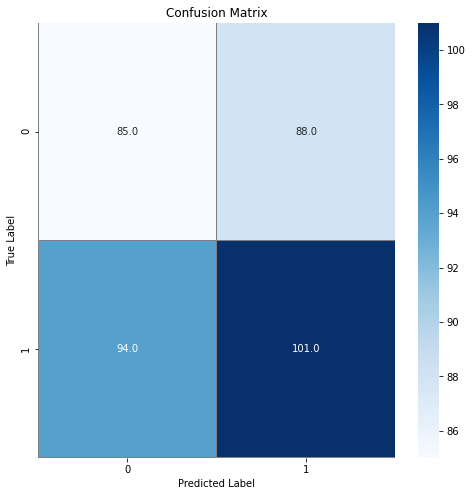

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predict the values from the validation dataset

loss, accuracy = vggmodel.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
y_pred =  vggmodel.predict_generator(dataset_test)
y_p = np.where(y_pred > 0.5, 1,0)
test_data=dataset_test.unbatch()
y_g=[]
for image, label in  test_data:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(y_g, y_p)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
confusion_mtx = confusion_matrix(y_g, y_p).ravel()
tn, fp, fn, tp =confusion_mtx
print("true positive",tp)
print("false positive",fp)
print("false negative",fn)
print("true negative",tn)
precision= tp / (tp + fp)
recall = tp / (tp + fn)
accuracy=(tp + tn)/(tp + tn + fp + fn)
f_measure = (2 * recall * precision) / (recall + precision)
print ("Accuracy", accuracy*100)
print ("Precision:", precision*100)
print (" Recall:", recall*100)
print("f_measure :", f_measure*100);


true positive 101
false positive 88
false negative 94
true negative 85
Accuracy 50.54347826086957
Precision: 53.43915343915344
 Recall: 51.7948717948718
f_measure : 52.60416666666667


In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#plot_model_history(hist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


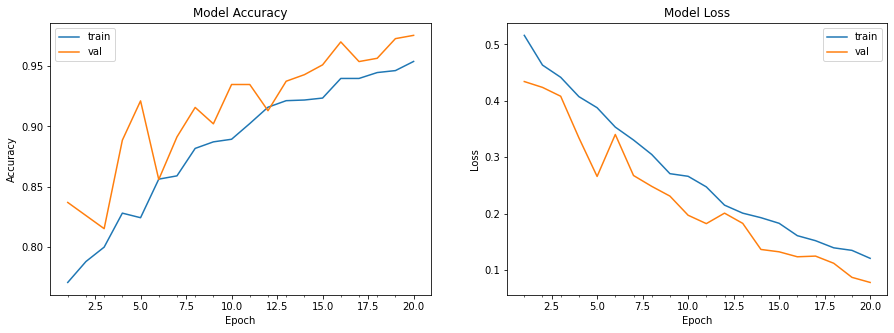

In [ ]:
plot_model_history(vgghist)

In [ ]:
loss, accuracy = vggmodel.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.978261  ;  loss = 0.080477 


In [ ]:
vgg_y_pred =  vggmodel.predict_generator(dataset_test)
vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_g, vgg_y_p).ravel()
print("true positive",tp)
print("false positive",fp)
print("false negative",fn)
print("true negative",tn)
precision= tp / (tp + fp)
recall = tp / (tp + fn)
accuracy=(tp + tn)/(tp + tn + fp + fn)
f_measure = (2 * recall * precision) / (recall + precision)
print ("Accuracy", accuracy*100)
print ("Precision:", precision*100)
print (" Recall:", recall*100)
print('f_measure :', f_measure*100);

true positive 313
false positive 71
false negative 74
true negative 10
Accuracy 69.01709401709401
Precision: 81.51041666666666
 Recall: 80.87855297157623
f_measure : 81.19325551232166


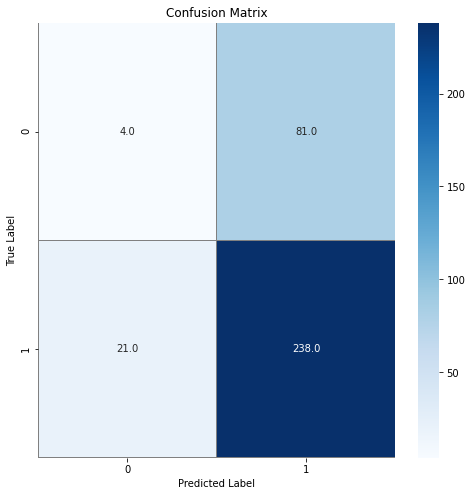

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_g, vgg_y_p)

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(y_g, vgg_y_p, target_names=['0','1'])
print(report)